<a href="https://colab.research.google.com/github/E-Eshbaugh/CryptoModel_v1/blob/main/CryptoModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## -- 9/22/2025 --


In [180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [181]:
# last year BTC prices
btc = yf.download('BTC-USD', period='5y')
print(btc.info())

/tmp/ipython-input-3897428234.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc = yf.download('BTC-USD', period='5y')
[*********************100%***********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1827 entries, 2020-09-25 to 2025-09-25
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Close, BTC-USD)   1827 non-null   float64
 1   (High, BTC-USD)    1827 non-null   float64
 2   (Low, BTC-USD)     1827 non-null   float64
 3   (Open, BTC-USD)    1827 non-null   float64
 4   (Volume, BTC-USD)  1827 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 85.6 KB
None


Price              Close          High           Low          Open  \
Ticker           BTC-USD       BTC-USD       BTC-USD       BTC-USD   
Date                                                                 
2020-10-01  10619.452148  10933.624023  10472.356445  10795.254883   
2020-10-02  10575.974609  10657.837891  10416.689453  10619.821289   
2020-10-03  10549.329102  10598.940430  10511.129883  10575.100586   
2020-10-04  10669.583008  10686.000000  10534.391602  10550.440430   
2020-10-05  10793.339844  10793.507812  10634.600586  10676.529297   

Price            Volume     7-Day_SMA  
Ticker          BTC-USD                
Date                                   
2020-10-01  40023134100  10739.563756  
2020-10-02  48661453918  10722.886300  
2020-10-03  44660271563  10694.115653  
2020-10-04  71251776995  10679.017578  
2020-10-05  47537578009  10690.972935  


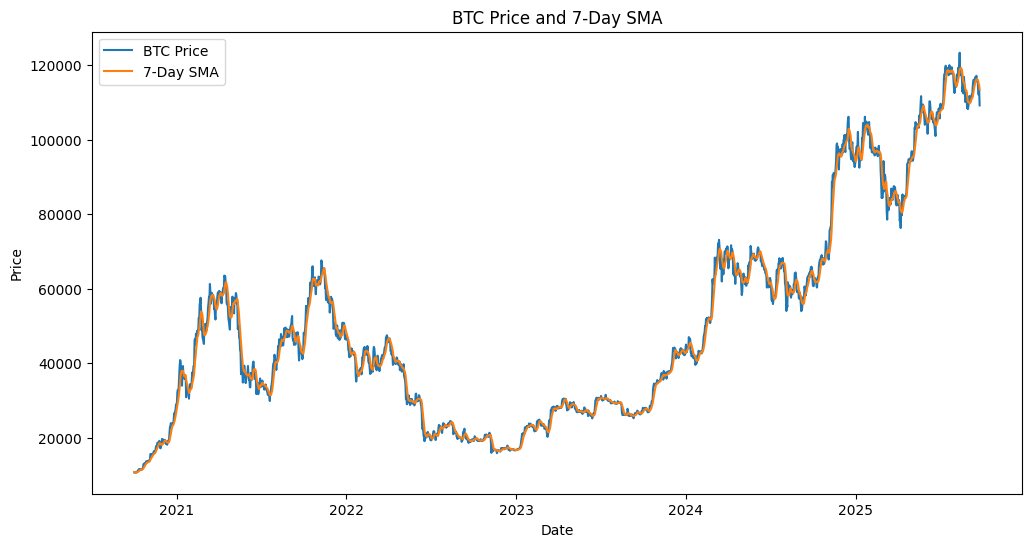

In [182]:
btc['7-Day_SMA'] = btc['Close'].rolling(window=7).mean()
btc = btc.dropna()
print(btc.head())

plot = plt.figure(figsize=(12, 6))
plt.plot(btc['Close'], label='BTC Price')
plt.plot(btc['7-Day_SMA'], label='7-Day SMA')
plt.title('BTC Price and 7-Day SMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## -- 9/24/2025 --


In [183]:
# Setting up column for price up (1) or down (0) on the next day.
btc['Next_Day_Movement'] = np.where(btc['Close'].shift(-1) > btc['Close'], 1, 0)
print(btc.head())

Price              Close          High           Low          Open  \
Ticker           BTC-USD       BTC-USD       BTC-USD       BTC-USD   
Date                                                                 
2020-10-01  10619.452148  10933.624023  10472.356445  10795.254883   
2020-10-02  10575.974609  10657.837891  10416.689453  10619.821289   
2020-10-03  10549.329102  10598.940430  10511.129883  10575.100586   
2020-10-04  10669.583008  10686.000000  10534.391602  10550.440430   
2020-10-05  10793.339844  10793.507812  10634.600586  10676.529297   

Price            Volume     7-Day_SMA Next_Day_Movement  
Ticker          BTC-USD                                  
Date                                                     
2020-10-01  40023134100  10739.563756                 0  
2020-10-02  48661453918  10722.886300                 0  
2020-10-03  44660271563  10694.115653                 1  
2020-10-04  71251776995  10679.017578                 1  
2020-10-05  47537578009  10690.97

In [184]:
# Adding RSI calculations

def calculate_rsi(prices, window=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

btc['RSI'] = calculate_rsi(btc['Close'])
btc = btc.dropna()
print(btc.head())

Price              Close          High           Low          Open  \
Ticker           BTC-USD       BTC-USD       BTC-USD       BTC-USD   
Date                                                                 
2020-10-14  11429.506836  11539.977539  11307.831055  11429.047852   
2020-10-15  11495.349609  11569.914062  11303.603516  11426.602539   
2020-10-16  11322.123047  11540.061523  11223.012695  11502.828125   
2020-10-17  11358.101562  11386.261719  11285.345703  11322.123047   
2020-10-18  11483.359375  11483.359375  11347.578125  11355.982422   

Price            Volume     7-Day_SMA Next_Day_Movement        RSI  
Ticker          BTC-USD                                             
Date                                                                
2020-10-14  24103426719  11295.922294                 1  75.520033  
2020-10-15  24487233058  11378.731445                 0  76.495162  
2020-10-16  25635480772  11415.540737                 1  70.927629  
2020-10-17  19130430174  

In [185]:
# Adding MACD measurements as well
# Going to keep the EMA calculations for 26, 12, and 9 period as well

btc['EMA_26'] = btc['Close'].ewm(span=26, adjust=False).mean()
btc['EMA_12'] = btc['Close'].ewm(span=12, adjust=False).mean()

btc['MACD'] = btc['EMA_12'] - btc['EMA_26']
btc['Signal_Line'] = btc['MACD'].ewm(span=9, adjust=False).mean()
btc = btc.dropna()
print(btc.head())

Price              Close          High           Low          Open  \
Ticker           BTC-USD       BTC-USD       BTC-USD       BTC-USD   
Date                                                                 
2020-10-14  11429.506836  11539.977539  11307.831055  11429.047852   
2020-10-15  11495.349609  11569.914062  11303.603516  11426.602539   
2020-10-16  11322.123047  11540.061523  11223.012695  11502.828125   
2020-10-17  11358.101562  11386.261719  11285.345703  11322.123047   
2020-10-18  11483.359375  11483.359375  11347.578125  11355.982422   

Price            Volume     7-Day_SMA Next_Day_Movement        RSI  \
Ticker          BTC-USD                                              
Date                                                                 
2020-10-14  24103426719  11295.922294                 1  75.520033   
2020-10-15  24487233058  11378.731445                 0  76.495162   
2020-10-16  25635480772  11415.540737                 1  70.927629   
2020-10-17  1913043

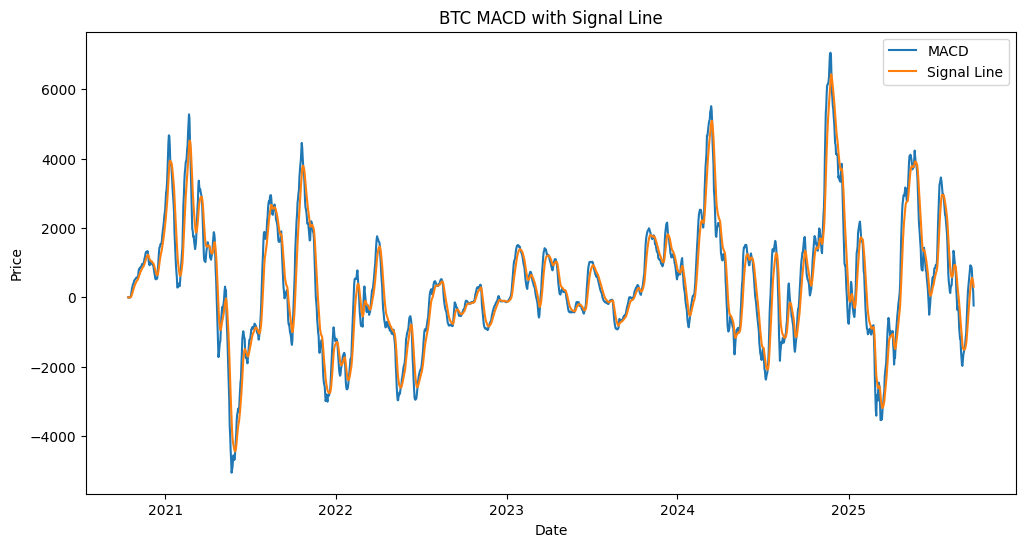

In [186]:
# Plot MACD (with signal line)

plot = plt.figure(figsize=(12, 6))
plt.plot(btc['MACD'], label='MACD')
plt.plot(btc['Signal_Line'], label='Signal Line')
plt.title('BTC MACD with Signal Line')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

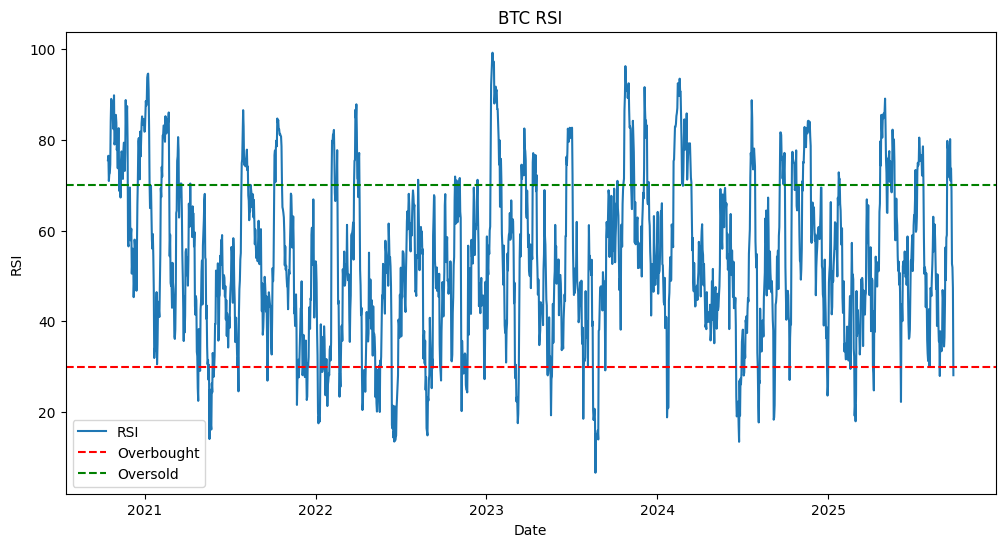

In [187]:
# Plot RSI

plot = plt.figure(figsize=(12, 6))
plt.plot(btc['RSI'], label='RSI')
plt.axhline(y=30, color='r', linestyle='--', label='Overbought')
plt.axhline(y=70, color='g', linestyle='--', label='Oversold')
plt.title('BTC RSI')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.show()

## -- 9/25/2025 --

In [188]:
# First RF Classifer off of data currently using time series slicing. Predicting poor performance - no regime classification, mostly short term trend behavior metrics
X = btc[['7-Day_SMA', 'RSI', 'MACD', 'Signal_Line']].shift(1)
y = btc['Next_Day_Movement']

model = RandomForestClassifier(n_estimators=300, max_depth=6, random_state=42)
tscv = TimeSeriesSplit(n_splits=5)

accuracies = []
for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    accuracies.append(acc)

print("Fold accuracies:", accuracies)
print("Mean accuracy:", np.mean(accuracies))

baseline_acc = (y == 1).mean()
print("Baseline accuracy:", baseline_acc)


Fold accuracies: [0.5448504983388704, 0.45182724252491696, 0.5083056478405316, 0.5149501661129569, 0.4019933554817276]
Mean accuracy: 0.48438538205980075
Baseline accuracy: 0.5060840707964602


Price              Close          High           Low          Open  \
Ticker           BTC-USD       BTC-USD       BTC-USD       BTC-USD   
Date                                                                 
2021-01-21  30825.699219  35552.679688  30250.750000  35549.398438   
2021-01-22  33005.761719  33811.851562  28953.373047  30817.625000   
2021-01-23  32067.642578  33360.976562  31493.160156  32985.757812   
2021-01-24  32289.378906  32944.007812  31106.685547  32064.376953   
2021-01-25  32366.392578  34802.742188  32087.787109  32285.798828   

Price            Volume     7-Day_SMA Next_Day_Movement        RSI  \
Ticker          BTC-USD                                              
Date                                                                 
2021-01-21  75643067688  35409.730469                 1  31.899143   
2021-01-22  77207272511  34864.072545                 0  34.005765   
2021-01-23  48354737975  34276.858538                 1  33.463043   
2021-01-24  4864383

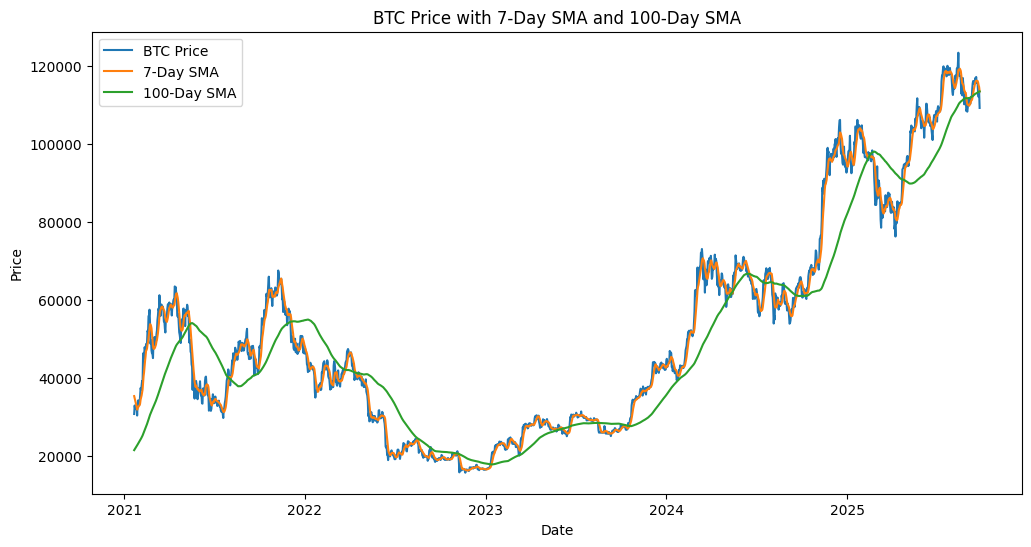

In [189]:
# add a 100-day SMA for more long term
btc['100-Day_SMA'] = btc['Close'].rolling(window=100).mean()
btc = btc.dropna()
print(btc.head())

plot = plt.figure(figsize=(12, 6))
plt.plot(btc['Close'], label='BTC Price')
plt.plot(btc['7-Day_SMA'], label='7-Day SMA')
plt.plot(btc['100-Day_SMA'], label='100-Day SMA')
plt.title('BTC Price with 7-Day SMA and 100-Day SMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

Price              Close          High           Low          Open  \
Ticker           BTC-USD       BTC-USD       BTC-USD       BTC-USD   
Date                                                                 
2021-08-09  46365.402344  46456.832031  42848.687500  43791.925781   
2021-08-10  45585.031250  46637.988281  44705.554688  46280.847656   
2021-08-11  45593.636719  46735.632812  45351.710938  45599.703125   
2021-08-12  44428.289062  46228.910156  43861.445312  45576.878906   
2021-08-13  47793.320312  47831.976562  44282.417969  44439.691406   

Price            Volume     7-Day_SMA Next_Day_Movement        RSI  \
Ticker          BTC-USD                                              
Date                                                                 
2021-08-09  38734079049  42329.408482                 0  74.127886   
2021-08-10  33546019517  43391.130022                 1  67.733429   
2021-08-11  34319709073  44226.291853                 0  66.621354   
2021-08-12  3372362

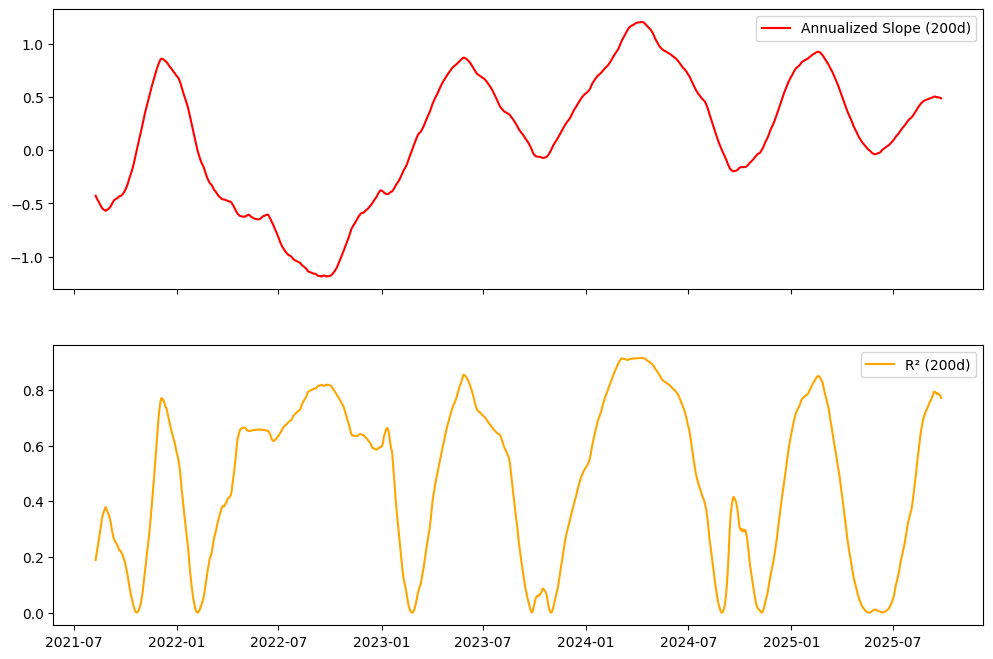

In [190]:
# Adding a 200-day slope with R^2 value to look at regime behavior changes

def rolling_trend_features(df, window=200):
    y = np.log(df[('Close', 'BTC-USD')])
    x = np.arange(len(y), dtype=float)

    slopes = pd.Series(index=df.index, dtype=float)
    r2s = pd.Series(index=df.index, dtype=float)

    for i in range(window, len(df)):
        yi = y.iloc[i-window:i]
        xi = x[i-window:i]

        A = np.vstack([xi, np.ones(len(xi))]).T
        coefficients = np.linalg.lstsq(A, yi, rcond=None)[0]
        beta = float(coefficients[0])
        alpha = float(coefficients[1])

        yhat = alpha + beta * xi
        ss_res = ((yi.to_numpy() - yhat)**2).sum()
        ss_tot = ((yi - yi.mean())**2).sum()
        r2 = 1 - ss_res/ss_tot if float(ss_tot) > 0 else np.nan

        slopes.iloc[i] = beta
        r2s.iloc[i] = r2

    return slopes.rename(f"slope_{window}"), r2s.rename(f"r2_{window}")

btc["slope_200"], btc["r2_200"] = rolling_trend_features(btc, 200)
btc["slope_200_annualized"] = btc["slope_200"] * 252
btc = btc.dropna()
print(btc.head())

fig, ax = plt.subplots(2, 1, figsize=(12,8), sharex=True)
ax[0].plot(btc.index, btc["slope_200_annualized"], label="Annualized Slope (200d)", color="red")
ax[0].legend()
ax[1].plot(btc.index, btc["r2_200"], label="R² (200d)", color="orange")
ax[1].legend()
plt.show()


In [196]:
# Label regimes SLOPE_DOWN, SLOPE_UP, CHOP
def label_regime(r2, slope_ann, r2_hi=0.30, r2_lo=0.20, s_hi=0.25, s_lo=0.10):
    r2_scalar = r2.item() if isinstance(r2, pd.Series) else r2
    slope_ann_scalar = slope_ann.item() if isinstance(slope_ann, pd.Series) else slope_ann

    if (r2_scalar >= r2_hi) and (abs(slope_ann_scalar) >= s_hi):
        return "TREND_UP" if slope_ann_scalar > 0 else "TREND_DOWN"
    if (r2_scalar <= r2_lo) or (abs(slope_ann_scalar) < s_lo):
        return "CHOP"
    return "NEUTRAL"

btc['Regime'] = btc.apply(lambda x: label_regime(x["r2_200"], x["slope_200_annualized"]), axis=1)
print(btc['Regime'].value_counts())

Regime
TREND_UP      655
CHOP          363
TREND_DOWN    345
NEUTRAL       146
Name: count, dtype: int64
